# Overfitting and Double Descents

## Abstract

In this blog post, I explore the deep learning phenomenon of overfitting and the resulting double descent. First, I created a linear regression model and an overparameterized optimizer that could fit the model to the data. For the first visualization, I tested model predictions after fitting it to the data. Then I used my model to calculate the number of corruptions in an image. To measure model performance, I calculated mean squared error (MSE) and graphed how it changes as the number of features increased. In this visualization, I observed double descent on the testing set. I found that the optimal number of features was beyond the interpolation threshold at 192 features with an MSE of 301s.

In [1]:
%load_ext autoreload
%autoreload 2

### Random Features Generation

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def sig(x): 
    return 1/(1+torch.exp(-x))

def square(x): 
    return x**2

class RandomFeatures:
    """
    Random sigmoidal feature map. This feature map must be "fit" before use, like this: 

    phi = RandomFeatures(n_features = 10)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    model.fit(X_train_phi, y_train)
    model.score(X_test_phi, y_test)

    It is important to fit the feature map once on the training set and zero times on the test set. 
    """

    def __init__(self, n_features, activation = sig):
        self.n_features = n_features
        self.u = None
        self.b = None
        self.activation = activation

    def fit(self, X):
        self.u = torch.randn((X.size()[1], self.n_features), dtype = torch.float64)
        self.b = torch.rand((self.n_features), dtype = torch.float64) 

    def transform(self, X: torch.Tensor):
        return self.activation(X @ self.u + self.b)

<!-- ## Part 0

If p > n, then $(X^T X)^{-1}$ is not invertible. The matrix is rank-deficient. -->

## Testing MyLinearRegression Model

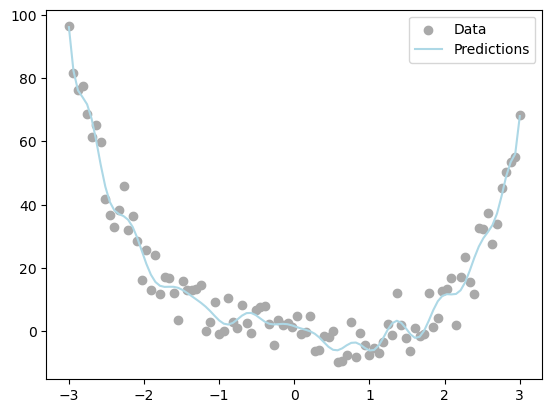

In [3]:
from MyLinearRegression import MyLinearRegression, OverParameterizedLinearRegressionOptimizer

X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

phi = RandomFeatures(n_features= 100)
phi.fit(X)
X_train_features = phi.transform(X)

LR = MyLinearRegression()
opt = OverParameterizedLinearRegressionOptimizer(LR)
opt.fit(X_train_features, y)
pred = LR.predict(X_train_features)
line = pred.numpy() 

plt.scatter(X, y, color='darkgrey', label='Data')
plt.plot(X, line, color='lightblue', label="Predictions")
plt.legend()
plt.show()

I tested the linear regression model on 1D data. The model seemed to produce accurate predictions.

## Corrupted Flower Images

Cells 5 to 9 were adapted from Prof. Phil's code as background for the corrupted flower images.

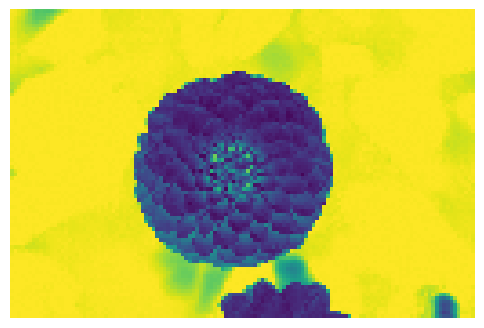

In [4]:
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom

dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X, .2) # decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower)
off = ax.axis("off")
plt.show()

In [5]:
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

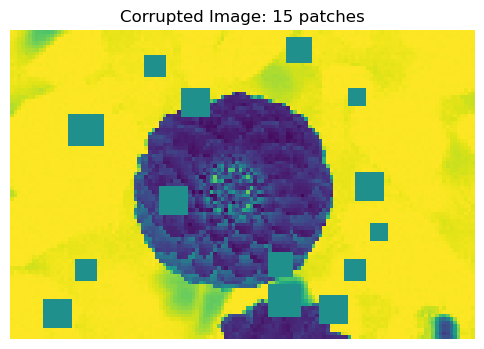

In [6]:
X, y = corrupted_image(flower, mean_patches = 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1)
ax.set(title = f"Corrupted Image: {y} patches")
off = plt.gca().axis("off")
plt.show()

In [7]:
n_samples = 200

X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64)
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

In [8]:
from sklearn.model_selection import train_test_split

X = X.reshape(n_samples, -1)
# X.reshape(n_samples, -1).size()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

### Performance of Model

Here I assess the performance of my model by calculating the mean squared error (MSE) and plotting it against the number of features for both training and testing sets.

In [11]:
n_features = 200

train_loss_vec = []
test_loss_vec = []

n = X_train.size()[0] 

# Loop over different numbers of random features
for i in range(n_features):
    # Initialize the random feature transformation
    phi = RandomFeatures(n_features = i, activation = square)
    phi.fit(X_train) # Fit the random features to the training data
    
    # Transform both training and test data using the fitted feature map
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)
    
    # Initialize the linear regression model and optimizer
    LR = MyLinearRegression()
    opt = OverParameterizedLinearRegressionOptimizer(LR)
    
    # Fit the model to the transformed training data
    opt.fit(X_train_phi, y_train)
    
    # Compute training and testing loss (MSE)
    train_loss = LR.loss(X_train_phi, y_train).item()
    test_loss = LR.loss(X_test_phi, y_test).item()
    
    # Append the losses to the respective lists
    train_loss_vec.append(train_loss)
    test_loss_vec.append(test_loss)

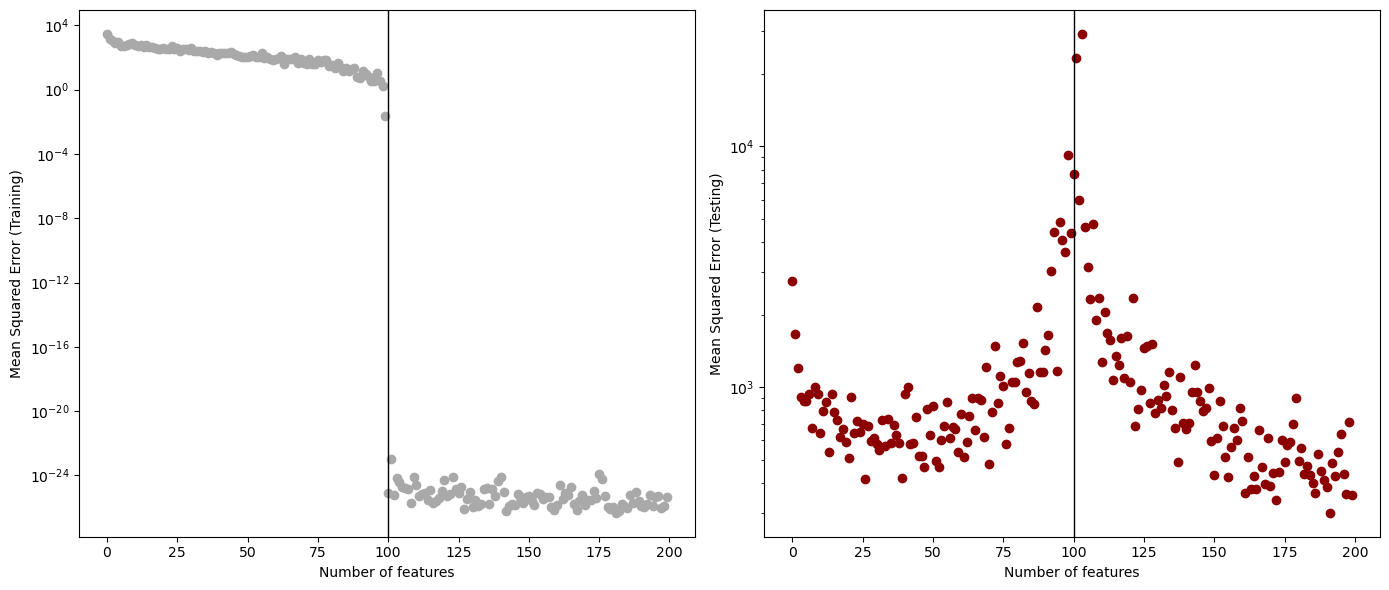

Lowest test loss: 300.5068 at 192 features.


In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  

# Plot training loss
ax[0].scatter(range(n_features), train_loss_vec, color='darkgrey')
ax[0].set_yscale('log')
ax[0].axvline(n, color='black', linewidth = 1)
ax[0].set_xlabel("Number of features")
ax[0].set_ylabel("Mean Squared Error (Training)")

# Plot testing loss
ax[1].scatter(range(n_features), test_loss_vec, color='darkred')
ax[1].set_yscale('log')
ax[1].axvline(n, color='black', linewidth = 1)
ax[1].set_xlabel("Number of features")
ax[1].set_ylabel("Mean Squared Error (Testing)")

plt.tight_layout()
plt.show()

# Find the best number of features with the lowest test loss
best_idx = torch.tensor(test_loss_vec).argmin().item() # convert vector to tensor and get index of minimum
best_features = best_idx + 1 
best_loss = test_loss_vec[best_idx]

print(f"Lowest test loss: {best_loss:.4f} at {best_features} features.")

For the training data, I observed that as the number of features increased, the MSE decreased. In particular, at 100 features, which was the interpolation threshold, the MSE dropped dramatically from approximately $10^{-4}$ to $10^{-22}$.

For the testing data, I observed that the MSE decreased as the number of features increased, but then increased again after a certain point, indicating overfitting. Following the interpolation threshold, the error started to decrease again. The best error rate for the testing set was around 301 at 192 features, which was after the interpolation threshold.

## Discussion

My most important finding was that my model does achieve double descent. For training loss, the MSE continued to trend downward as the number of features increased. For testing loss, there was an initial decrease in loss, but then the loss rose when it reached near the interpolation threshold due to overfitting. After the interpolation threshold, the loss decreased again, reaching a second minimum.

Based on my results, 192 features achieved the lowest MSE of 301.

<!-- This blog post was my first time creating a fit function for a machine learning model. I also improved my overall graphing skills, such as adding lines to scatter plots and implementing interpolation methods. Additionally, using logarithmic scales was a new technique for me. -->